### data 읽기

In [1]:
import numpy as np
import dicom
import os

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

c:\users\ddk13\appdata\local\programs\python\python36\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=5):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

In [3]:
id=2
output_path = working_path = '01_export_data/'
imgs_dicom_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

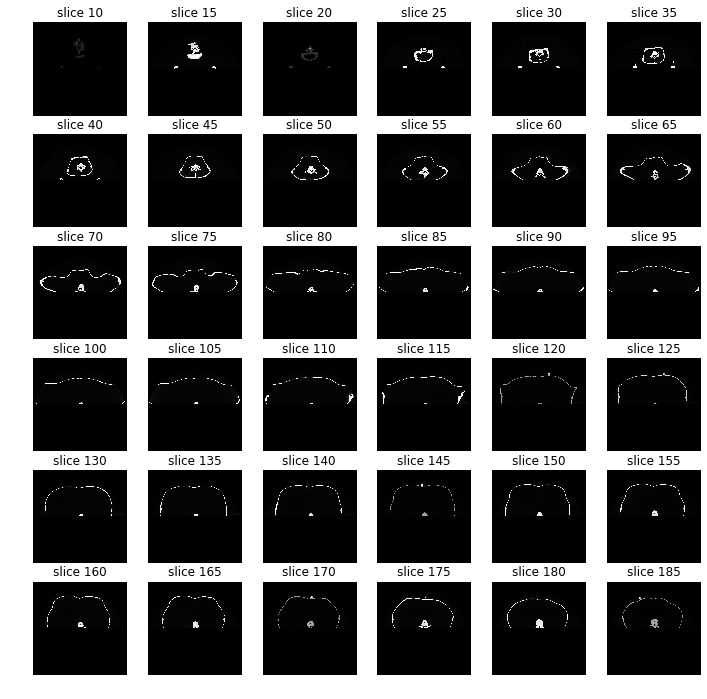

In [4]:
# check a image
# 512 * 512
sample_stack(imgs_dicom_to_process)

### dilation

In [39]:
from skimage.morphology import disk, dilation

num_of_dicom_data = len(imgs_dicom_to_process)
imgs_dicom_to_process_dilation = []

for i in range(num_of_dicom_data):
    mask = disk(3)
    img = dilation(imgs_dicom_to_process[i], selem=mask)
    imgs_dicom_to_process_dilation.append(img)

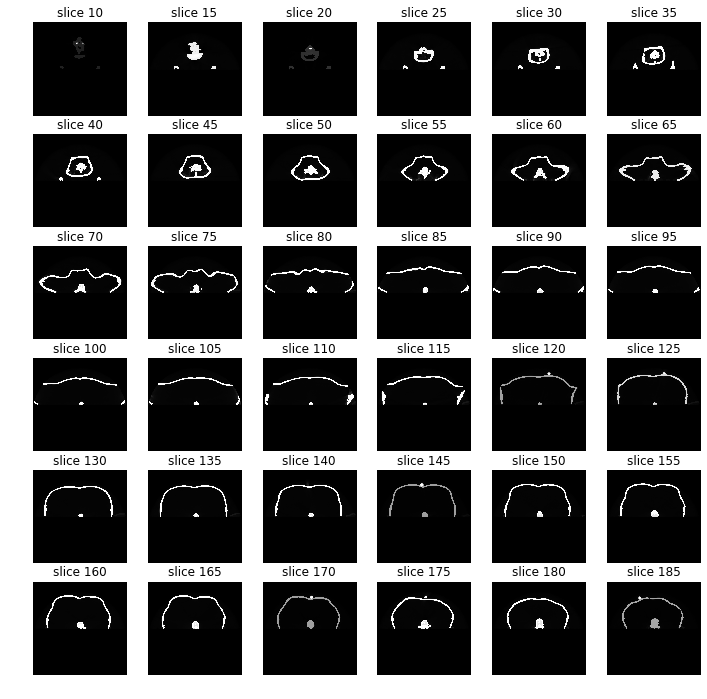

In [40]:
# check a image
# 512 * 512
sample_stack(imgs_dicom_to_process_dilation)

### contour detection

In [43]:
from skimage.morphology import disk, erosion
from skimage import measure
from PIL import Image, ImageDraw

imgs_dicom_to_process_contour = []

for i in range(num_of_dicom_data):

    # Construct some test data
    r = imgs_dicom_to_process_dilation[i]

    # Find contours at a constant value of 0.8
    contours = measure.find_contours(r, 0.8)

    contour_surf = contours[0]
    
    polygon = []

    for p in range(len(contour_surf)):
        polygon.append((contour_surf[p][1], contour_surf[p][0]))

    # polygon = [(x1,y1),(x2,y2),...]
    width = 512
    height = 512

    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    mask = np.array(img)
    
    mask_ers = erosion(mask, selem=disk(3))
    
    imgs_dicom_to_process_contour.append(mask_ers)

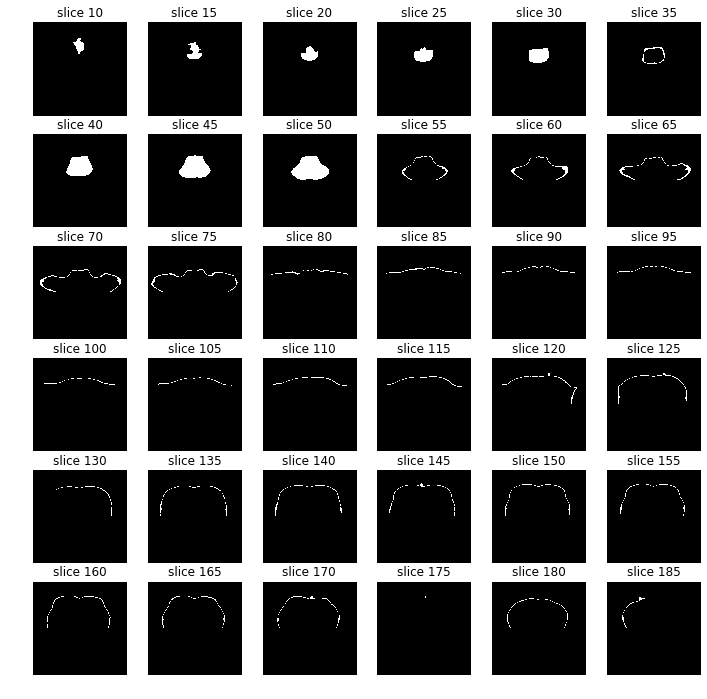

In [44]:
# check a image
# 512 * 512
sample_stack(imgs_dicom_to_process_contour)

### make mesh obj

In [45]:
from skimage import morphology
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def make_and_save_mesh_to_obj(image, threshold=-300, step_size=1, slice_thickness=1.0):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, normals, val = measure.marching_cubes_lewiner(p, threshold, spacing=(1.0, 1.0, slice_thickness), 
                                                                step_size=step_size, allow_degenerate=True) 
    faces = faces + 1
    
    thefile = open('test__.obj', 'w')
    for item in verts:
        thefile.write("v {0} {1} {2}\n".format(item[0],item[1],item[2]))

    for item in normals:
        thefile.write("vn {0} {1} {2}\n".format(item[0],item[1],item[2]))

    for item in faces:
        thefile.write("f {0}//{0} {1}//{1} {2}//{2}\n".format(item[0],item[1],item[2]))  

    thefile.close()
    
    print("fin.")
    
    return True

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()

In [45]:
v, f = make_mesh(imgs_dicom_to_process_contour, 0, 3)

Transposing surface
Calculating surface


In [ ]:
%matplotlib notebook
plotly_3d(v, f)

In [ ]:
make_and_save_mesh_to_obj(np.array(imgs_dicom_to_process_contour), 0, 1, 2)

Transposing surface
Calculating surface
